## pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]

print(train.shape, test.shape, sub.shape)

(5000000, 3) (2000000, 2) (2000000, 2)


In [3]:
train["local_time"] = train.time % 50
train.loc[train.local_time == 0.0000, "local_time"] = 50

test["local_time"] = test.time % 50
test.loc[test.local_time == 0.0000, "local_time"] = 50

test["mini_local_time"] = test.time % 10
test.loc[test.local_time == 0.0000, "mini_local_time"] = 10

In [4]:
BATCH_SIZE = 500000

# train
for batch_i in range(10):
    train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# test
for batch_i in range(4):
    test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5

In [5]:
print(train.shape, test.shape, sub.shape)

train.head()

(5000000, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [6]:
test.head()

,time,signal,local_time,mini_local_time,batch,mini_batch
0,500.0001,-2.6498,0.0001,0.0001,1.0,1.0
1,500.0002,-2.8494,0.0002,0.0002,1.0,1.0
2,500.0003,-2.8600,0.0003,0.0003,1.0,1.0
3,500.0004,-2.4350,0.0004,0.0004,1.0,1.0
4,500.0005,-2.6155,0.0005,0.0005,1.0,1.0


In [7]:
drift_preset = 2.73
order_4_params = np.array([0, 3.1e-1, 1e-3, -3e-4, 3e-6])


##  channel 0

In [8]:
############### channel 0 ###############

In [9]:
# channel 0 - batch 1
channel_0_batch_1 = train[(train.batch == 1) & (train.open_channels == 0)]
channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
train.loc[(train.batch == 1) & (train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [10]:
# channel 0 - batch 2 - 1
channel_0_batch_2_1 = train[(train.batch == 2) & (train.mini_batch == 1) &
                            (train.open_channels == 0)]

X = np.array(channel_0_batch_2_1["local_time"]).reshape([-1, 1])
y = np.array(channel_0_batch_2_1["signal"]).reshape([-1, 1])

reg_0_batch_2_1 = LinearRegression().fit(X, y)

slope, intercept = reg_0_batch_2_1.coef_[0][0], reg_0_batch_2_1.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

channel_0_batch_2_1["signal_recover"] = channel_0_batch_2_1.signal - y_fit + intercept

train.loc[(train.batch == 2) & (train.mini_batch == 1) &
          (train.open_channels == 0),
          "signal"] = channel_0_batch_2_1["signal_recover"]

In [11]:
print(slope, intercept)

0.3 -2.6847823929742463


In [12]:
# channel 0 - batch 5 (drift, discard for now)
train = train.drop(train[(train.batch == 5) & (train.open_channels == 0)].index)

In [13]:
# channel 0 - batch 7
channel_0_batch_7 = train[(train.batch == 7) & (train.open_channels == 0)]

X = np.array(channel_0_batch_7["local_time"]).reshape([-1, 1])
y = np.array(channel_0_batch_7["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_0_batch_7 = LinearRegression().fit(x_poly, y)
reg_0_batch_7.coef_ = order_4_params

y_fit = reg_0_batch_7.predict(x_poly)

channel_0_batch_7["signal_recover"] = channel_0_batch_7.signal - y_fit.reshape(
    -1) + reg_0_batch_7.intercept_

train.loc[(train.batch == 7) & (train.open_channels == 0),
          "signal"] = channel_0_batch_7["signal_recover"]

In [14]:
# channel 0 - batch 8 (noise, discard for now)
train = train.drop(train[(train.batch == 8) & (train.open_channels == 0)].index)

In [15]:
# channel 0 - batch 9
channel_0_batch_9 = train[(train.batch == 9) & (train.open_channels == 0)]

X = np.array(channel_0_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_0_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_0_batch_9 = LinearRegression().fit(x_poly, y)
reg_0_batch_9.coef_ = order_4_params

y_fit = reg_0_batch_9.predict(x_poly)

channel_0_batch_9["signal_recover"] = channel_0_batch_9.signal - y_fit.reshape(
    -1) + reg_0_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 0),
          "signal"] = channel_0_batch_9["signal_recover"]

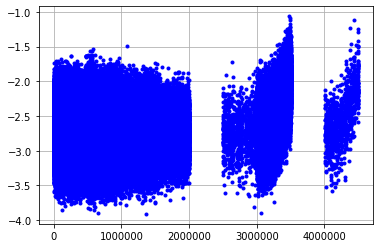

In [16]:
plt.plot(train[train.open_channels == 0].signal, ".b")
plt.grid()

## channel 1

In [17]:
############### channel 1 ###############

In [18]:
### channel 1 batch 2 - 1
channel_1_batch_2_1 = train[(train.batch == 2) & (train.mini_batch == 1) &
                            (train.open_channels == 1)]

X = np.array(channel_1_batch_2_1["local_time"]).reshape([-1, 1])
y = np.array(channel_1_batch_2_1["signal"]).reshape([-1, 1])

reg_1_batch_2_1 = LinearRegression().fit(X, y)

slope, intercept = reg_1_batch_2_1.coef_[0][0], reg_1_batch_2_1.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

channel_1_batch_2_1["signal_recover"] = channel_1_batch_2_1.signal - y_fit + intercept

train.loc[(train.batch == 2) & (train.mini_batch == 1) &
          (train.open_channels == 1),
          "signal"] = channel_1_batch_2_1["signal_recover"]

In [19]:
print(slope, intercept)

0.3 -1.4653515148207135


In [20]:
# channel 1 - batch 5 and 10 (drift, discard for now)
train = train.drop(train[(train.batch == 5) & (train.open_channels == 1)].index)
train = train.drop(train[(train.batch == 10) & (train.open_channels == 1)].index)

In [21]:
# channel 1 - batch 7
channel_1_batch_7 = train[(train.batch == 7) & (train.open_channels == 1)]

X = np.array(channel_1_batch_7["local_time"]).reshape([-1, 1])
y = np.array(channel_1_batch_7["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_1_batch_7 = LinearRegression().fit(x_poly, y)
reg_1_batch_7.coef_ = order_4_params

y_fit = reg_1_batch_7.predict(x_poly)

channel_1_batch_7["signal_recover"] = channel_1_batch_7.signal - y_fit.reshape(
    -1) + reg_1_batch_7.intercept_

train.loc[(train.batch == 7) & (train.open_channels == 1),
          "signal"] = channel_1_batch_7["signal_recover"]

In [22]:
# channel 1 - batch 8 (noise, discard for now)
train = train.drop(train[(train.batch == 8) & (train.open_channels == 1)].index)

In [23]:
# channel 1 - batch 9
channel_1_batch_9 = train[(train.batch == 9) & (train.open_channels == 1)]

X = np.array(channel_1_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_1_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_1_batch_9 = LinearRegression().fit(x_poly, y)
reg_1_batch_9.coef_ = order_4_params

y_fit = reg_1_batch_9.predict(x_poly)

channel_1_batch_9["signal_recover"] = channel_1_batch_9.signal - y_fit.reshape(
    -1) + reg_1_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 1),
          "signal"] = channel_1_batch_9["signal_recover"]

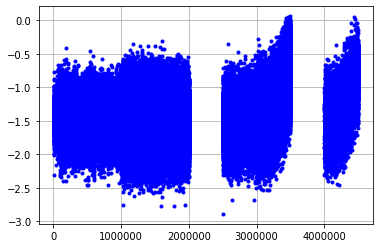

In [24]:
plt.plot(train[train.open_channels == 1].signal, ".b")
plt.grid()

## channel 2

In [25]:
############### channel 2 ###############

In [26]:
# channel 2 - batch 8 (noise, discard for now)
train = train.drop(train[(train.batch == 8) & (train.open_channels == 2)].index)

In [27]:
# channel 2 - batch 9
channel_2_batch_9 = train[(train.batch == 9) & (train.open_channels == 2)]

X = np.array(channel_2_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_2_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_2_batch_9 = LinearRegression().fit(x_poly, y)
reg_2_batch_9.coef_ = order_4_params

y_fit = reg_2_batch_9.predict(x_poly)

channel_2_batch_9["signal_recover"] = channel_2_batch_9.signal - y_fit.reshape(
    -1) + reg_2_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 2),
          "signal"] = channel_2_batch_9["signal_recover"]

In [28]:
# channel 2 - batch 10
channel_2_batch_10 = train[(train.batch == 10) & (train.open_channels == 2)]

X = np.array(channel_2_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_2_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_2_batch_10 = LinearRegression().fit(x_poly, y)
reg_2_batch_10.coef_ = order_4_params

y_fit = reg_2_batch_10.predict(x_poly)

channel_2_batch_10["signal_recover"] = channel_2_batch_10.signal - y_fit.reshape(
    -1) + reg_2_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 2),
          "signal"] = channel_2_batch_10["signal_recover"]

In [29]:
# channel 2 - drift in batch 5 & 10
channel_2_mean = train[(train.batch.isin([4, 6, 9]))
                       & (train.open_channels == 2)].signal.mean()

channel_2_drift_mean = np.mean([
    train[(train.batch == 5) & (train.open_channels == 2)].signal.mean(),
    train[(train.batch == 10) & (train.open_channels == 2)].signal.mean()
])

channel_2_drift = channel_2_mean - channel_2_drift_mean

channel_2_drift = drift_preset

train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 2),
          "signal"] += channel_2_drift

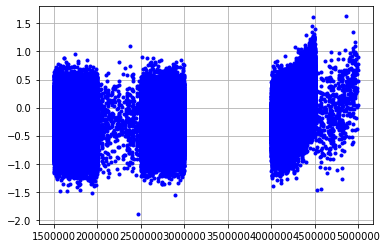

In [30]:
plt.plot(train[train.open_channels == 2].signal, ".b")
plt.grid()

## channel 3

In [31]:
############### channel 3 ###############

In [32]:
# channel 3 - batch 8 (noise, discard for now)
train = train.drop(train[(train.batch == 8) & (train.open_channels == 3)].index)

In [33]:
# channel 3 - batch 9
channel_3_batch_9 = train[(train.batch == 9) & (train.open_channels == 3)]

X = np.array(channel_3_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_3_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_3_batch_9 = LinearRegression().fit(x_poly, y)
reg_3_batch_9.coef_ = order_4_params

y_fit = reg_3_batch_9.predict(x_poly)

channel_3_batch_9["signal_recover"] = channel_3_batch_9.signal - y_fit.reshape(
    -1) + reg_3_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 3),
          "signal"] = channel_3_batch_9["signal_recover"]

In [34]:
# channel 3 - batch 10
channel_3_batch_10 = train[(train.batch == 10) & (train.open_channels == 3)]

X = np.array(channel_3_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_3_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_3_batch_10 = LinearRegression().fit(x_poly, y)
reg_3_batch_10.coef_ = order_4_params

y_fit = reg_3_batch_10.predict(x_poly)

channel_3_batch_10["signal_recover"] = channel_3_batch_10.signal - y_fit.reshape(
    -1) + reg_3_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 3),
          "signal"] = channel_3_batch_10["signal_recover"]

In [35]:
# channel 3 - mean, drift-mean, drift
channel_3_mean = train[(train.batch.isin([4, 6, 9]))
                       & (train.open_channels == 3)].signal.mean()
channel_3_drift_mean = train[(train.batch.isin([5, 10]))
                             & (train.open_channels == 3)].signal.mean()
channel_3_drift = channel_3_mean - channel_3_drift_mean

channel_3_drift = drift_preset

train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 3),
          "signal"] += channel_3_drift

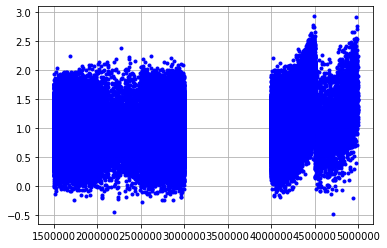

In [36]:
plt.plot(train[train.open_channels == 3].signal, ".b")
plt.grid()

## channel 4

In [37]:
############### channel 4 ###############

In [38]:
# channel 4 - batch 9
channel_4_batch_9 = train[(train.batch == 9) & (train.open_channels == 4)]

X = np.array(channel_4_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_4_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_4_batch_9 = LinearRegression().fit(x_poly, y)
reg_4_batch_9.coef_ = order_4_params

y_fit = reg_4_batch_9.predict(x_poly)

channel_4_batch_9["signal_recover"] = channel_4_batch_9.signal - y_fit.reshape(
    -1) + reg_4_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 4),
          "signal"] = channel_4_batch_9["signal_recover"]

In [39]:
# channel 4 - batch 10
channel_4_batch_10 = train[(train.batch == 10) & (train.open_channels == 4)]

X = np.array(channel_4_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_4_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_4_batch_10 = LinearRegression().fit(x_poly, y)
reg_4_batch_10.coef_ = order_4_params

y_fit = reg_4_batch_10.predict(x_poly)

channel_4_batch_10["signal_recover"] = channel_4_batch_10.signal - y_fit.reshape(
    -1) + reg_4_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 4),
          "signal"] = channel_4_batch_10["signal_recover"]

In [40]:
# channel 4 - mean, drift-mean, drift
channel_4_mean = train[(train.batch.isin([6, 9]))
                       & (train.open_channels == 4)].signal.mean()
channel_4_drift_mean = train[(train.batch.isin([5, 10]))
                             & (train.open_channels == 4)].signal.mean()
channel_4_drift = channel_4_mean - channel_4_drift_mean

channel_4_drift = drift_preset

train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 4),
          "signal"] += channel_4_drift

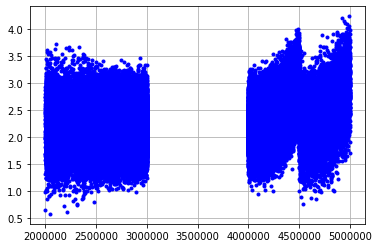

In [41]:
plt.plot(train[train.open_channels == 4].signal, ".b")
plt.grid()

## channel 5

In [42]:
############### channel 5 ###############

In [43]:
# channel 5 - batch 9
channel_5_batch_9 = train[(train.batch == 9) & (train.open_channels == 5)]

X = np.array(channel_5_batch_9["local_time"]).reshape([-1, 1])
y = np.array(channel_5_batch_9["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_5_batch_9 = LinearRegression().fit(x_poly, y)
reg_5_batch_9.coef_ = order_4_params

y_fit = reg_5_batch_9.predict(x_poly)

channel_5_batch_9["signal_recover"] = channel_5_batch_9.signal - y_fit.reshape(
    -1) + reg_5_batch_9.intercept_

train.loc[(train.batch == 9) & (train.open_channels == 5),
          "signal"] = channel_5_batch_9["signal_recover"]

In [44]:
# channel 5 - batch 10
channel_5_batch_10 = train[(train.batch == 10) & (train.open_channels == 5)]

X = np.array(channel_5_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_5_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_5_batch_10 = LinearRegression().fit(x_poly, y)
reg_5_batch_10.coef_ = order_4_params

y_fit = reg_5_batch_10.predict(x_poly)

channel_5_batch_10["signal_recover"] = channel_5_batch_10.signal - y_fit.reshape(
    -1) + reg_5_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 5),
          "signal"] = channel_5_batch_10["signal_recover"]

In [45]:
# channel 5 - mean, drift-mean, drift
channel_5_mean = train[(train.batch.isin([6, 9]))
                       & (train.open_channels == 5)].signal.mean()
channel_5_drift_mean = train[(train.batch.isin([5, 10]))
                             & (train.open_channels == 5)].signal.mean()
channel_5_drift = channel_5_mean - channel_5_drift_mean

channel_5_drift = drift_preset

train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 5),
          "signal"] += channel_5_drift

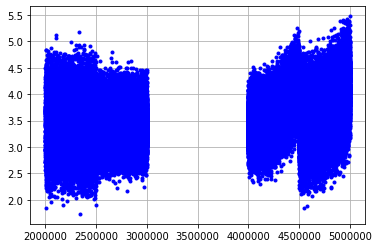

In [46]:
plt.plot(train[train.open_channels == 5].signal, ".b")
plt.grid()

In [47]:
# print(channel_2_drift.round(4))
# print(channel_3_drift.round(4))
# print(channel_4_drift.round(4))
# print(channel_5_drift.round(4))

DRIFT = np.mean(
    [channel_2_drift, channel_3_drift, channel_4_drift,
     channel_5_drift]).round(4)
print("shift is", DRIFT)

shift is 2.73


## channel 6

In [48]:
############### channel 6 ###############

In [49]:
# channel 6 - drift
train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 6),
          "signal"] += DRIFT

In [50]:
# channel 6 - batch 10
channel_6_batch_10 = train[(train.batch == 10) & (train.open_channels == 6)]

X = np.array(channel_6_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_6_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_6_batch_10 = LinearRegression().fit(x_poly, y)
reg_6_batch_10.coef_ = order_4_params

y_fit = reg_6_batch_10.predict(x_poly)

channel_6_batch_10["signal_recover"] = channel_6_batch_10.signal - y_fit.reshape(
    -1) + reg_6_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 6),
          "signal"] = channel_6_batch_10["signal_recover"]

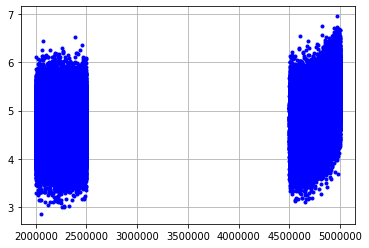

In [51]:
plt.plot(train[train.open_channels == 6].signal, ".b")
plt.grid()

## channel 7

In [52]:
############### channel 7 ###############

In [53]:
# channel 7 - drift
train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 7),
          "signal"] += DRIFT

In [54]:
# channel 7 - batch 10
channel_7_batch_10 = train[(train.batch == 10) & (train.open_channels == 7)]

X = np.array(channel_7_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_7_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_7_batch_10 = LinearRegression().fit(x_poly, y)
reg_7_batch_10.coef_ = order_4_params

y_fit = reg_7_batch_10.predict(x_poly)

channel_7_batch_10["signal_recover"] = channel_7_batch_10.signal - y_fit.reshape(
    -1) + reg_7_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 7),
          "signal"] = channel_7_batch_10["signal_recover"]

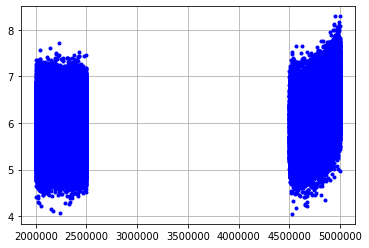

In [55]:
plt.plot(train[train.open_channels == 7].signal, ".b")
plt.grid()

## channel 8

In [56]:
############### channel 8 ###############

In [57]:
# channel 8 - drift
train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 8),
          "signal"] += DRIFT

In [58]:
# channel 8 - batch 10
channel_8_batch_10 = train[(train.batch == 10) & (train.open_channels == 8)]

X = np.array(channel_8_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_8_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_8_batch_10 = LinearRegression().fit(x_poly, y)
reg_8_batch_10.coef_ = order_4_params

y_fit = reg_8_batch_10.predict(x_poly)

channel_8_batch_10["signal_recover"] = channel_8_batch_10.signal - y_fit.reshape(
    -1) + reg_8_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 8),
          "signal"] = channel_8_batch_10["signal_recover"]

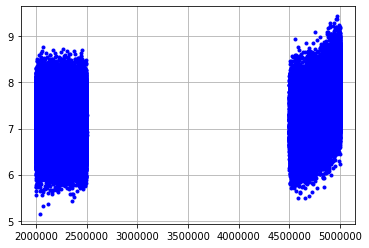

In [59]:
plt.plot(train[train.open_channels == 8].signal, ".b")
plt.grid()

## channel 9

In [60]:
############### channel 9 ###############

In [61]:
# channel 9 - drift
train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 9),
          "signal"] += DRIFT

In [62]:
# channel 9 - batch 10
channel_9_batch_10 = train[(train.batch == 10) & (train.open_channels == 9)]

X = np.array(channel_9_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_9_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_9_batch_10 = LinearRegression().fit(x_poly, y)
reg_9_batch_10.coef_ = order_4_params

y_fit = reg_9_batch_10.predict(x_poly)

channel_9_batch_10["signal_recover"] = channel_9_batch_10.signal - y_fit.reshape(
    -1) + reg_9_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 9),
          "signal"] = channel_9_batch_10["signal_recover"]

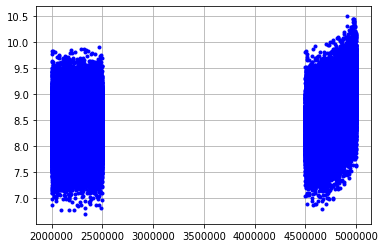

In [63]:
plt.plot(train[train.open_channels == 9].signal, ".b")
plt.grid()

## channel 10

In [64]:
############### channel 10 ###############

In [65]:
# channel 10 - drift
train.loc[(train.batch.isin([5, 10])) & (train.open_channels == 10),
          "signal"] += DRIFT

In [66]:
# channel 5 - batch 10
channel_10_batch_10 = train[(train.batch == 10) & (train.open_channels == 10)]

X = np.array(channel_10_batch_10["local_time"]).reshape([-1, 1])
y = np.array(channel_10_batch_10["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_10_batch_10 = LinearRegression().fit(x_poly, y)
reg_10_batch_10.coef_ = order_4_params

y_fit = reg_10_batch_10.predict(x_poly)

channel_10_batch_10["signal_recover"] = channel_10_batch_10.signal - y_fit.reshape(
    -1) + reg_10_batch_10.intercept_

train.loc[(train.batch == 10) & (train.open_channels == 10),
          "signal"] = channel_10_batch_10["signal_recover"]

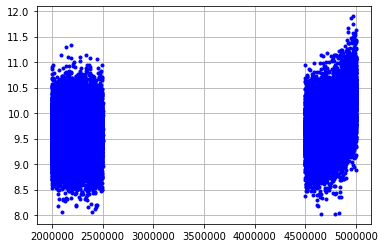

In [67]:
plt.plot(train[train.open_channels == 10].signal, ".b")
plt.grid()

## visualization

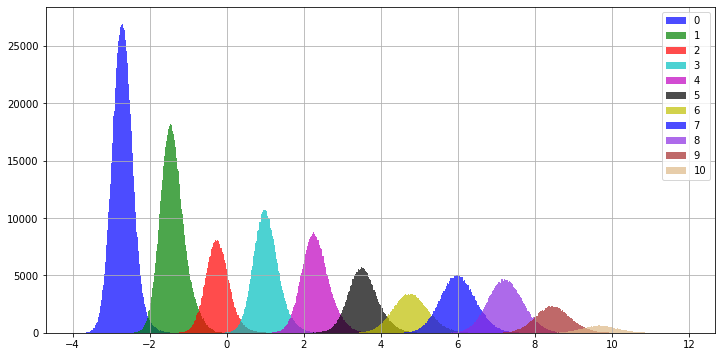

In [68]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]
fig = plt.figure(figsize=(12, 6))
for channel_i in range(11):
#     plt.plot(train[train.open_channels == channel_i].signal,".", color= color_list[channel_i], alpha=0.05)
    train[train.open_channels == channel_i].signal.hist(
            bins=200, alpha=0.7, color=color_list[channel_i], label=channel_i)
plt.legend()

## gmm model

In [69]:
### learn the distribution of each channel

In [70]:
def get_mean_cov(x):

    gmm = GaussianMixture(n_components=1)
    gmm.fit(x)
    ms = gmm.means_
    ps = gmm.precisions_

    return ms[0][0], ps[0][0][0]

In [71]:
gmm_mean = []
gmm_cov = []
for channel_i in range(11):
    channel = np.array(train[train.open_channels == channel_i].signal).reshape([-1,1])
    ms, ps = get_mean_cov(channel)
    gmm_mean.append(ms)
    gmm_cov.append(ps)
gmm_mean = np.array(gmm_mean).reshape([-1,1])
gmm_cov = np.array(gmm_cov).reshape([-1,1,1])

print(gmm_mean.shape, gmm_cov.shape)

(11, 1) (11, 1, 1)


In [72]:
print("============ channel 0 ============")
print(reg_0_batch_7.coef_, reg_0_batch_7.intercept_)
print(reg_0_batch_9.coef_, reg_0_batch_9.intercept_)
print("============ channel 1 ============")
print(reg_1_batch_7.coef_, reg_1_batch_7.intercept_)
print(reg_1_batch_9.coef_, reg_1_batch_9.intercept_)
print("============ channel 2 ============")
print(reg_2_batch_9.coef_, reg_2_batch_9.intercept_)
print(reg_2_batch_10.coef_, reg_2_batch_10.intercept_)
print("============ channel 3 ============")
print(reg_3_batch_9.coef_, reg_3_batch_9.intercept_)
print(reg_3_batch_10.coef_, reg_3_batch_10.intercept_)
print("============ channel 4 ============")
print(reg_4_batch_9.coef_, reg_4_batch_9.intercept_)
print(reg_4_batch_10.coef_, reg_4_batch_10.intercept_)
print("============ channel 5 ============")
print(reg_5_batch_9.coef_, reg_5_batch_9.intercept_)
print(reg_5_batch_10.coef_, reg_5_batch_10.intercept_)
print("============ channel 6 ============")
print(reg_6_batch_10.coef_, reg_6_batch_10.intercept_)
print("============ channel 7 ============")
print(reg_7_batch_10.coef_, reg_7_batch_10.intercept_)
print("============ channel 8 ============")
print(reg_8_batch_10.coef_, reg_8_batch_10.intercept_)
print("============ channel 9 ============")
print(reg_9_batch_10.coef_, reg_9_batch_10.intercept_)
print("============ channel 10 ============")
print(reg_10_batch_10.coef_, reg_10_batch_10.intercept_)


============ channel 0 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-2.73079015]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-2.6947169]
============ channel 1 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-1.49886744]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-1.52134236]
============ channel 2 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-0.28321413]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-3.01052381]
============ channel 3 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [0.95812908]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-1.86073016]
============ channel 4 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [2.19478111]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [-0.50406131]
============ channel 5 ============
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [3.43303533]
[ 0.0e+00  3.1e-01  1.0e-03 -3.0e-04  3.0e-06] [0.71564575]
============ channel 6 ============
[ 0.0e+00  3.1e-01  1

In [73]:
np.diff(gmm_mean.round(3),axis=0).mean()

1.2417

In [74]:
print(np.diff(gmm_mean.round(3),axis=0))

[[1.299]
 [1.17 ]
 [1.263]
 [1.281]
 [1.237]
 [1.237]
 [1.233]
 [1.235]
 [1.231]
 [1.231]]


In [75]:
gmm_mean.round(3)

array([[-2.703],
       [-1.404],
       [-0.234],
       [ 1.029],
       [ 2.31 ],
       [ 3.547],
       [ 4.784],
       [ 6.017],
       [ 7.252],
       [ 8.483],
       [ 9.714]])

In [76]:
gmm_cov.round(3)

array([[[13.91 ]],

       [[10.171]],

       [[10.636]],

       [[ 9.279]],

       [[ 7.754]],

       [[ 6.634]],

       [[ 4.773]],

       [[ 4.798]],

       [[ 4.806]],

       [[ 4.823]],

       [[ 4.783]]])

In [77]:
# np.diff(gmm_cov.round(3),axis=0)

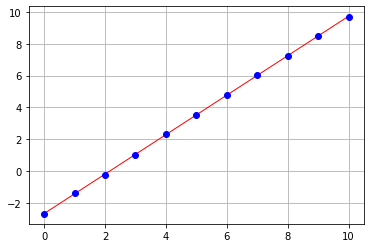

In [78]:
line = LinearRegression().fit(np.array(range(11)).reshape([-1,1]), gmm_mean)

slope, intercept = line.coef_[0][0], line.intercept_[0]
y_fit = [slope * i + intercept for i in np.array(range(11)).reshape([-1,1])]


plt.plot(y_fit,"r",lw=1)
plt.plot(gmm_mean, ".b",markersize=12)
plt.grid()

In [79]:
print(np.array(y_fit).reshape([1,-1])[0].round(3))
print(gmm_mean.reshape([1,-1])[0].round(3))

[-2.68  -1.439 -0.197  1.044  2.285  3.527  4.768  6.009  7.251  8.492
  9.733]
[-2.703 -1.404 -0.234  1.029  2.31   3.547  4.784  6.017  7.252  8.483
  9.714]


In [80]:
# gmm = GaussianMixture(n_components=11,
#                       init_params='kmeans',
#                       covariance_type='full',
#                       max_iter=500,
#                       n_init=10,
#                       random_state=42,
#                       means_init=gmm_mean,
#                       precisions_init=gmm_cov
#                      )

# signal = np.array(train.signal).reshape([-1, 1])
# gmm.fit(signal)

In [81]:
# df_train = np.array(train.signal).reshape([-1,1])
# train["oof"] = gmm.predict(df_train)

# print("Macro F1 score is:", f1_score(train.oof, train.open_channels, average='macro'))

## process test

In [82]:
test.head() 

,time,signal,local_time,mini_local_time,batch,mini_batch
0,500.0001,-2.6498,0.0001,0.0001,1.0,1.0
1,500.0002,-2.8494,0.0002,0.0002,1.0,1.0
2,500.0003,-2.8600,0.0003,0.0003,1.0,1.0
3,500.0004,-2.4350,0.0004,0.0004,1.0,1.0
4,500.0005,-2.6155,0.0005,0.0005,1.0,1.0


### batch 11

In [83]:
############### batch 11 ###############

In [84]:
### mini batch 11-1
test_batch_1_1 = test[(test.batch == 1) & (test.mini_batch == 1)]

In [85]:
X = np.array(test_batch_1_1["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_1_1["signal"]).reshape([-1, 1])

reg_test_batch_1_1 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_1_1.coef_[0][0], reg_1_batch_2_1.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_1_1["signal_recover"] = test_batch_1_1.signal - y_fit + intercept

test.loc[(test.batch == 1) & (test.mini_batch == 1),
          "signal"] = test_batch_1_1["signal_recover"]

In [86]:
print(slope, intercept)

0.3 -1.4653515148207135


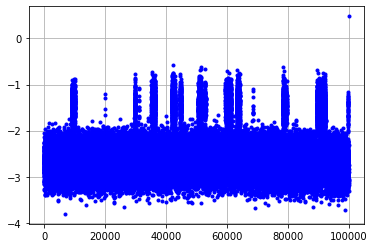

In [87]:
plt.plot(test[(test.batch == 1) & (test.mini_batch == 1)].signal, ".b")
plt.grid()

In [88]:
### mini batch 11-2
test_batch_1_2 = test[(test.batch == 1) & (test.mini_batch == 2)]

In [89]:
X = np.array(test_batch_1_2["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_1_2["signal"]).reshape([-1, 1])

reg_test_batch_1_2 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_1_2.coef_[0][0], reg_test_batch_1_2.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_1_2["signal_recover"] = test_batch_1_2.signal - y_fit + intercept

test.loc[(test.batch == 1) & (test.mini_batch == 2),
          "signal"] = test_batch_1_2["signal_recover"]

In [90]:
print(slope, intercept)

0.3 -0.11479924300352917


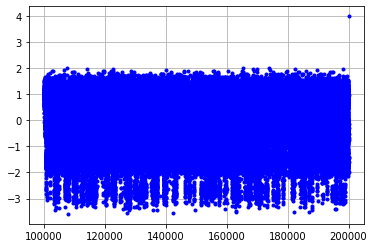

In [91]:
plt.plot(test[(test.batch == 1) & (test.mini_batch == 2)].signal, ".b")
plt.grid()

In [92]:
### mini batch 11-3

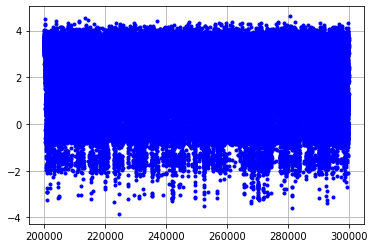

In [93]:
plt.plot(test[(test.batch == 1) & (test.mini_batch == 3)].signal, ".b")
plt.grid()

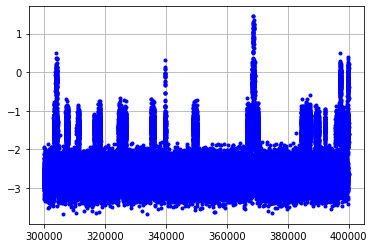

In [94]:
### mini batch 11-4
plt.plot(test[(test.batch == 1) & (test.mini_batch == 4)].signal, ".b")
plt.grid()

In [95]:
### mini batch 11-5
test_batch_1_5 = test[(test.batch == 1) & (test.mini_batch == 5)]

In [96]:
X = np.array(test_batch_1_5["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_1_5["signal"]).reshape([-1, 1])

reg_test_batch_1_5 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_1_5.coef_[0][0], reg_test_batch_1_5.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_1_5["signal_recover"] = test_batch_1_5.signal - y_fit + intercept

test.loc[(test.batch == 1) & (test.mini_batch == 5),
          "signal"] = test_batch_1_5["signal_recover"]

In [97]:
print(slope, intercept)

0.3 -1.7393836258948259


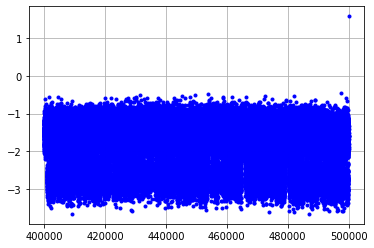

In [98]:
plt.plot(test[(test.batch == 1) & (test.mini_batch == 5)].signal, ".b")
plt.grid()

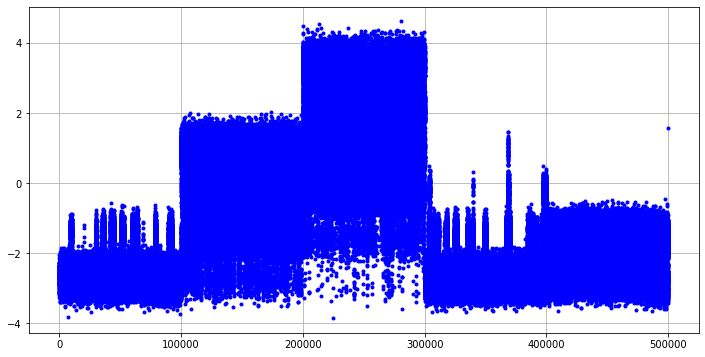

In [99]:
fig = plt.figure(figsize=(12, 6))
plt.plot(test[test.batch == 1].signal, ".b")
plt.grid()

### batch 12

In [100]:
############### batch 12 ############### ***drift***

In [101]:
### mini batch 12-1

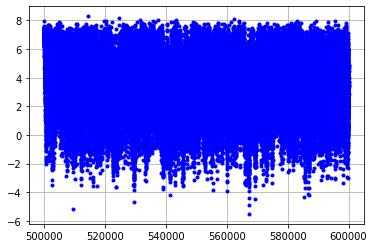

In [102]:
plt.plot(test[(test.batch == 2) & (test.mini_batch == 1)].signal, ".b")
plt.grid()

In [103]:
### mini batch 12-2
test_batch_2_2 = test[(test.batch == 2) & (test.mini_batch == 2)]

In [104]:
X = np.array(test_batch_2_2["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_2_2["signal"]).reshape([-1, 1])

reg_test_batch_2_2 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_2_2.coef_[0][0], reg_test_batch_2_2.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_2_2["signal_recover"] = test_batch_2_2.signal - y_fit + intercept

test.loc[(test.batch == 2) & (test.mini_batch == 2),
          "signal"] = test_batch_2_2["signal_recover"]

In [105]:
print(slope, intercept)

0.3 1.763095330944407


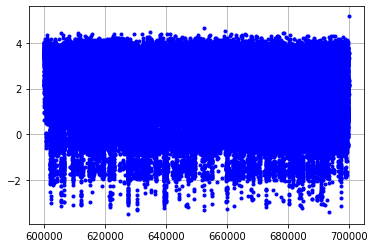

In [106]:
plt.plot(test[(test.batch == 2) & (test.mini_batch == 2)].signal, ".b")
plt.grid()

In [107]:
### mini batch 12-3
test_batch_2_3 = test[(test.batch == 2) & (test.mini_batch == 3)]

In [108]:
X = np.array(test_batch_2_3["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_2_3["signal"]).reshape([-1, 1])

reg_test_batch_2_3 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_2_3.coef_[0][0], reg_test_batch_2_3.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_2_3["signal_recover"] = test_batch_2_3.signal - y_fit + intercept

test.loc[(test.batch == 2) & (test.mini_batch == 3),
          "signal"] = test_batch_2_3["signal_recover"]

In [109]:
print(slope, intercept)

0.3 3.3169209116285057


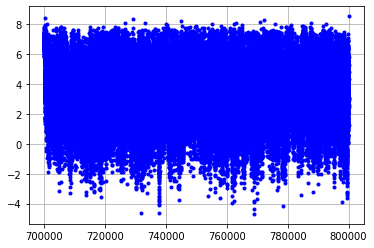

In [110]:
plt.plot(test[(test.batch == 2) & (test.mini_batch == 3)].signal, ".b")
plt.grid()

In [111]:
### mini batch 12-4
test_batch_2_4 = test[(test.batch == 2) & (test.mini_batch == 4)]

In [112]:
X = np.array(test_batch_2_4["mini_local_time"]).reshape([-1, 1])
y = np.array(test_batch_2_4["signal"]).reshape([-1, 1])

reg_test_batch_2_4 = LinearRegression().fit(X, y)

slope, intercept = reg_test_batch_2_4.coef_[0][0], reg_test_batch_2_4.intercept_[0]
slope = 0.3
y_fit = [slope * i + intercept for i in X[:,0]]

test_batch_2_4["signal_recover"] = test_batch_2_4.signal - y_fit + intercept

test.loc[(test.batch == 2) & (test.mini_batch == 4),
          "signal"] = test_batch_2_4["signal_recover"]

In [113]:
print(slope, intercept)

0.3 -2.605145895919943


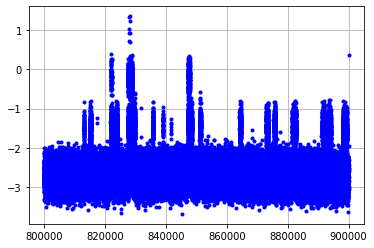

In [114]:
plt.plot(test[(test.batch == 2) & (test.mini_batch == 4)].signal, ".b")
plt.grid()

In [115]:
### mini batch 12-5

In [116]:
# might only 12-1 and 12-3 shift
# test.loc[test.batch == 2, "signal"] += DRIFT

# ################################################
test.loc[(test.batch == 2) & (test.mini_batch == 1), "signal"] += DRIFT
test.loc[(test.batch == 2) & (test.mini_batch == 3), "signal"] += DRIFT

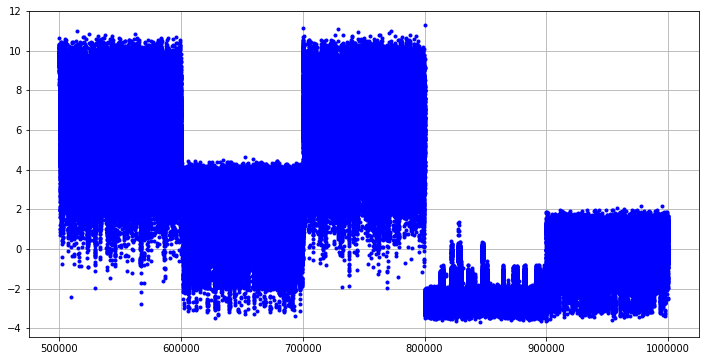

In [117]:
fig = plt.figure(figsize=(12, 6))
plt.plot(test[test.batch == 2].signal, ".b")
plt.grid()

### batch 13

In [118]:
############### batch 13 ###############
test_batch_3 = test[test.batch == 3]

In [119]:
X = np.array(test_batch_3["local_time"]).reshape([-1, 1])
y = np.array(test_batch_3["signal"]).reshape([-1, 1])

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

reg_batch_3 = LinearRegression().fit(x_poly, y)
y_fit = reg_batch_3.predict(x_poly)

test_batch_3["signal_recover"] = test_batch_3.signal - y_fit.reshape(
    -1) + reg_batch_3.intercept_

test.loc[test.batch == 3, "signal"] = test_batch_3["signal_recover"]

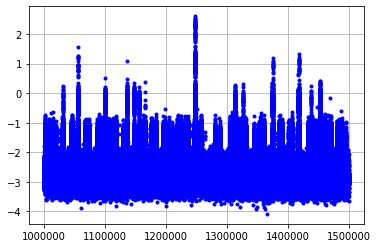

In [120]:
plt.plot(test[test.batch == 3].signal, ".b")
plt.grid()

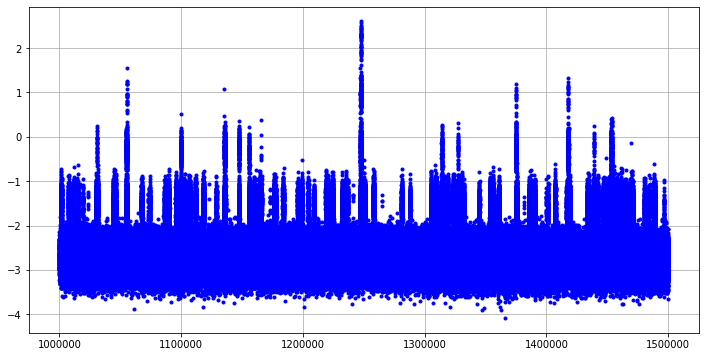

In [121]:
fig = plt.figure(figsize=(12, 6))
plt.plot(test[test.batch == 3].signal, ".b")
plt.grid()

### batch 14

In [122]:
############### batch 14 ###############

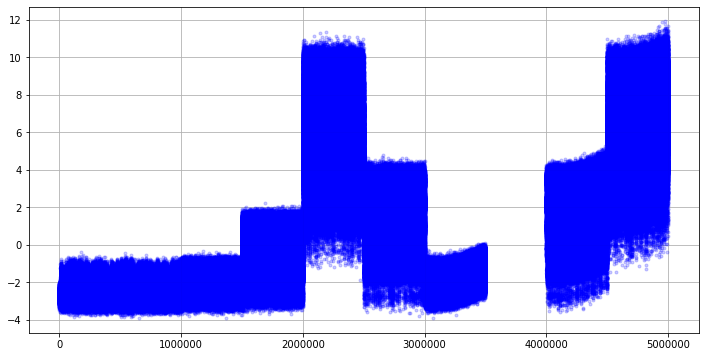

In [123]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train.signal, ".b", alpha=0.2)
plt.grid()

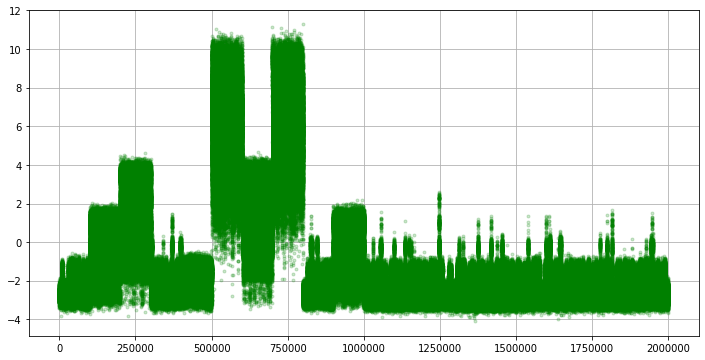

In [124]:
fig = plt.figure(figsize=(12, 6))
plt.plot(test.signal, ".g", alpha=0.2)
plt.grid()

In [125]:
train.head()

,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [126]:
test.head()

,time,signal,local_time,mini_local_time,batch,mini_batch
0,500.0001,-2.64983,0.0001,0.0001,1.0,1.0
1,500.0002,-2.84946,0.0002,0.0002,1.0,1.0
2,500.0003,-2.86009,0.0003,0.0003,1.0,1.0
3,500.0004,-2.43512,0.0004,0.0004,1.0,1.0
4,500.0005,-2.61565,0.0005,0.0005,1.0,1.0


In [127]:
print(train.shape, test.shape)
# train.to_pickle("../features/train_v2.pkl")
# test.to_pickle("../features/test_v2.pkl")

(4499872, 6) (2000000, 6)


## oof prediction

In [128]:
# fig = plt.figure(figsize=(12, 6))
# plt.grid()
# for channel_i in range(11):
#     plt.plot(train[train.open_channels == channel_i].signal,
#              ".",
#              color=color_list[channel_i],
#              alpha=0.01)

In [129]:
# df_train = np.array(train.signal).reshape([-1,1])
# train["oof"] = gmm.predict(df_train)

# print("Macro F1 score is:", f1_score(train.oof, train.open_channels, average='macro'))

In [130]:
# fig = plt.figure(figsize=(12, 6))
# plt.grid()
# for channel_i in range(11):
#     plt.plot(train[train.oof == channel_i].signal, ".", color=color_list[channel_i], alpha=0.01)

## prediction

In [131]:
# ############### predict ###############
# df_test = np.array(test.signal).reshape([-1,1])
# test["open_channels"]= gmm.predict(df_test)
# test["open_channels"].hist()

In [132]:
# fig = plt.figure(figsize=(12, 6))
# plt.grid()
# for channel_i in range(11):
#     plt.plot(test[test.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.05)

In [133]:
# sub["open_channels"] = test["open_channels"]
# sub.to_csv("../submissions/sub.csv", index=None)